In [41]:
%matplotlib inline
import torch
from torch import nn
from torch.utils import data
## lead helper functions from d2l
import sys
sys.path.insert(0, 'C:\\Users\\Shiwen\\dl_practice_pytorch\\function')
import d2l_torch as d2l

**generate data**

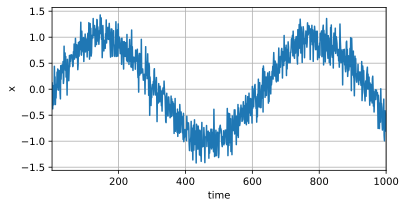

In [25]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0, 0.2, (T,))
# x = torch.sin(0.01*time)
# x = torch.normal(0, 0.2, (T,))
# x.shape
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize = (6, 3))

In [34]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:,i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

torch.Size([996, 1])

In [48]:
batch_size, n_train = 16, 600
train_data = (features[:n_train], labels[:n_train])
train_dataset = data.TensorDataset(*train_data)
train_iter = data.DataLoader(train_dataset, batch_size, shuffle=True)
print(type(train_dataset))
print(type(train_iter))

<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [50]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

In [51]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.064161
epoch 2, loss: 0.052586
epoch 3, loss: 0.049976
epoch 4, loss: 0.051451
epoch 5, loss: 0.051104


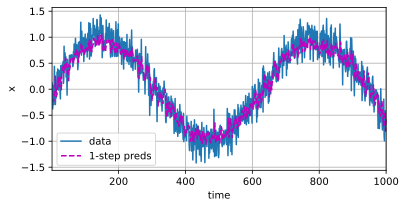

In [52]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

In [55]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

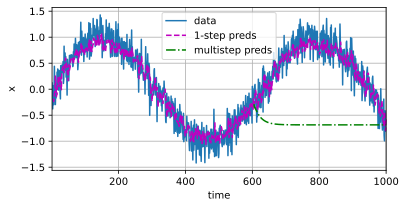

In [56]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
     [x.detach().numpy(), onestep_preds.detach().numpy(),
      multistep_preds[n_train + tau:].detach().numpy()], 'time',
     'x', legend=['data', '1-step preds', 'multistep preds'],
     xlim=[1, 1000], figsize=(6, 3))

In [57]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
    
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

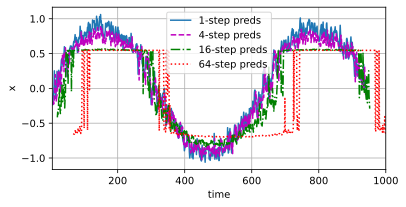

In [58]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))